In [14]:
# from tdmclient import ClientAsync, aw
# client = ClientAsync()
# node = await client.wait_for_node()
# aw(node.lock())

In [15]:
def find_keypoints_v1(path): #Version simple
 
    if len(path) < 3 :
        return path

    keypoints = [] 
    keypoints.append(path[0])

    for i in range(1, len(path) - 1):
        previous = path[i - 1]
        current = path[i]
        next = path[i + 1]

        # Direction vectors
        dir_previous = (current[0] - previous[0], current[1] - previous[1])
        dir_next = (next[0] - current[0], next[1] - current[1])

        if dir_previous != dir_next:
            keypoints.append(current)

    keypoints.append(path[len(path) - 1])  #last point of the path is the true final goal
    
    return keypoints

In [25]:
import math

def find_keypoints(path):
        
    def find_rotation(dir_previous,dir_next):
        det = dir_previous[0] * dir_next[1] - dir_previous[1] * dir_next[0]
        dot_product = dir_previous[0] * dir_next[0] + dir_previous[1] * dir_next[1]
        theta = math.atan2(det, dot_product) #oriented angle, in rad
        return theta

    #ANGLE_THRESHOLD = 0.15 #rad
    ANGLE_THRESHOLD = math.radians(40) #converts degrees to rad
    COUNTER_THRESHOLD = 3 #max number of steps between keypoints
    STEP = 3
        
    if len(path) < 3 :
        return path

    keypoints = [] 
    keypoints.append(path[0])
    counter = 1

    for i in range(STEP, len(path)-STEP, STEP): #beginning, max, step
        previous = path[i-STEP]
        current = path[i]
        next = path[i+STEP]

        #direction vectors
        dir_previous = (current[0] - previous[0], current[1] - previous[1])
        dir_next = (next[0] - current[0], next[1] - current[1])
        
        if (abs(find_rotation(dir_previous,dir_next)) > ANGLE_THRESHOLD): 
            keypoints.append(current)
            counter = 1
        elif (counter >= COUNTER_THRESHOLD): #ensures there isn't too much space between keypoints (so we avoid accumulating small changes of directions)
            keypoints.append(current)
            counter = 1
        else:
            counter += 1
            
    keypoints.append(path[len(path) - 1])  #last point of the path is the true final goal
    
    return keypoints

In [26]:
path = [
    (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9),
    (1, 10), (2, 11), (3, 12), (4, 13), (5, 14), (6, 15), (7, 16), 
    (8, 17), (9, 18), (10, 17), (11, 16), (12, 15), (13, 14), (14, 13), 
    (15, 12), (16, 11), (17, 11), (18, 12), (19, 13), (20, 14), (21, 15),
    (22, 16), (23, 17), (24, 18), (25, 19), (26, 20), (27, 21), (28, 22),
    (29, 23), (30, 24), (31, 25), (32, 26), (33, 27), (34, 28), (35, 29),
    (36, 29), (36, 28), (36, 27), (36, 26), (36, 25), (36, 24), (36, 23),
    (36, 22), (36, 21), (35, 21), (34, 21), (34, 22)
]
#random path for testing

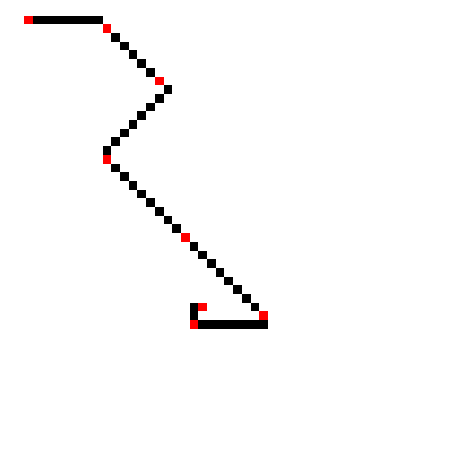

In [27]:
####Création et affichage d'une map pour tester la fonction find_keypoints

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def create_grid_map(size, path, keypoints):
    grid_map = np.ones(size) 
    for pos in path:
        grid_map[pos] = 0 
    for pos in keypoints:
        grid_map[pos] = 0.5  
    return grid_map

def display_grid_map(grid_map):
    # Define a direct mapping for colors: 0 -> black, 0.5 -> red, 1 -> white
    cmap = ListedColormap(["black", "red", "white"])
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_map, cmap=cmap, interpolation='nearest')
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()    

grid_side = 50
grid_size = (grid_side, grid_side)
#path = [(0,1), (1, 1), (2, 1), (3, 1), (4,2), (5,3), (6, 4), (7, 4), (8,4), (9,4), (9,5), (9,6), (8,6), (7,6), (6,7)]
keypoints = find_keypoints(path)

grid_map = create_grid_map(grid_size, path, keypoints)
display_grid_map(grid_map)

In [28]:
import math

def motion_control(x,y,theta,x_goal,y_goal):

    R_WHEEL = 4.3 #radius of the wheels
    L = 9.2 #wheel axis length
    DISTANCE_THRESHOLD = 1 #what is the unity of x and x_goal ?
    ANGLE_THRESHOLD = 0.1 #radians
    SPEED_LIMIT = 500

    def normalize_angle(angle): #restricts angle between -pi and pi
        while angle > math.pi:
            angle -= 2 * math.pi
        while angle < -math.pi:
            angle += 2 * math.pi
        return angle

    def goal_reached(distance_to_goal,delta_angle):
        return ((distance_to_goal<DISTANCE_THRESHOLD) and (abs(delta_angle)<DISTANCE_THRESHOLD))

    def limit_speed(v):
        if(v>SPEED_LIMIT) :
            v=SPEED_LIMIT
        if(v<-SPEED_LIMIT) :
            v=-SPEED_LIMIT
        return v
    
    #To do : Tune k by testing
    k_rho = 1.0 # To control linear velocity
    k_alpha = 3.0 # To control angular velocity 
    k_beta = -0.5 # Damping term (to stabilize the robot's orientation when reaching the goal)

    delta_x = x_goal - x
    delta_y = y_goal - y

    distance_to_goal =math.sqrt( (delta_x)**2 + (delta_y)**2 )
    delta_angle = normalize_angle(math.atan2(delta_y, delta_x) - theta) #difference between the robot's orientation and the direction of the goal

    v = k_rho*distance_to_goal #linear velocity
    omega = k_alpha*(delta_angle) - k_beta*(delta_angle+theta) #angular velocity
    
    #Calculate motor speed
    w_ml = (v-omega*L)/R_WHEEL #rad/s 
    w_mr = (v+omega*L)/R_WHEEL
    
    v_ml = w_ml*200/math.pi #PWM
    v_mr = w_mr*200/math.pi

    if(goal_reached(distance_to_goal,delta_angle)):
        v_ml=0
        v_mr=0

    v_ml = limit_speed(v_ml)
    v_mr = limit_speed(v_mr)

    v_m = {
        "motor.left.target": [v_ml],
        "motor.right.target": [v_mr],
    }
    
    return v_m

In [20]:
#v_m = motion_control(x,y,theta,x_goal,y_goal)
#await node.set_variables(v_m)

In [21]:
# # Stop the program
# aw(node.stop())
# aw(node.unlock())